In [1]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.svm import SVC

In [2]:
recipe_data = pd.read_csv('https://tf-assets-prod.s3.amazonaws.com/tf-curric/data-science/epi_r.csv')

## Explore and clean data

In [3]:
recipe_data.head()

,title,rating,calories,protein,fat,sodium,#cakeweek,#wasteless,22-minute meals,3-ingredient recipes,...,yellow squash,yogurt,yonkers,yuca,zucchini,cookbooks,leftovers,snack,snack week,turkey
0,"Lentil, Apple, and Turkey Wrap",2.500,426.0,30.0,7.0,559.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,Boudin Blanc Terrine with Red Onion Confit,4.375,403.0,18.0,23.0,1439.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Potato and Fennel Soup Hodge,3.750,165.0,6.0,7.0,165.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Mahi-Mahi in Tomato Olive Sauce,5.000,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Spinach Noodle Casserole,3.125,547.0,20.0,32.0,452.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
recipe_data.shape

(20052, 680)

In [5]:
## All columns except title, rating and nutritional info look like binary.

## Remove nutritional info because some nulls
## Also create binary rating (4+)

recipe_data_binary = recipe_data.drop(['calories', 'protein', 'fat', 'sodium'], axis=1)
recipe_data_binary['rating_4plus'] = np.where(recipe_data_binary['rating'] < 4, 0, 1)
recipe_data_features = recipe_data_binary.drop(['title', 'rating', 'rating_4plus'], axis=1)

## SVM models
### Attempt 1 = Most common variables

In [6]:
sums = list()

for col in recipe_data_features.columns:
    sums.append(recipe_data_features[col].sum())
len(sums)

674

In [7]:
totals = pd.DataFrame(
    columns = recipe_data_features.columns
)
for x in range(1):
    totals.loc[x] = sums
totals

,#cakeweek,#wasteless,22-minute meals,3-ingredient recipes,30 days of groceries,advance prep required,alabama,alaska,alcoholic,almond,...,yellow squash,yogurt,yonkers,yuca,zucchini,cookbooks,leftovers,snack,snack week,turkey
0,6.0,1.0,17.0,27.0,7.0,109.0,3.0,2.0,835.0,584.0,...,25.0,528.0,1.0,6.0,298.0,3.0,7.0,28.0,19.0,456.0


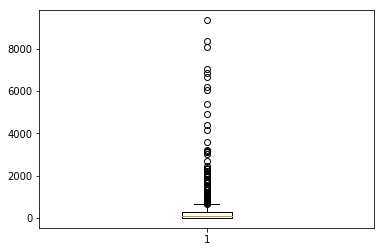

In [8]:
plt.boxplot(totals)
plt.show()

In [9]:
## Find top 30 variables on this measure

recipe_top_vars = recipe_data_features.loc[:, totals.loc[0, ] > 1780]
recipe_top_vars.shape

(20052, 30)

In [10]:
svm_top_vars = SVC()
x = recipe_top_vars
y = recipe_data_binary['rating_4plus']
svm_top_vars.fit(x, y)

/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [11]:
pd.crosstab(y, svm_top_vars.predict(x))

col_0,0,1
rating_4plus,,
0,3313,6001
1,2447,8291


In [12]:
svm_top_vars.score(x, y)

0.5786953919808497

### Attempt 2 = Features most correlated with output

In [13]:
corrs = list()
def rating_corr_list(features, ratings):
    for col in features.columns:
        data = pd.DataFrame()
        data[col] = features[col]
        data['rating_4plus'] = ratings['rating_4plus']
        corrmat = data.corr()
        corrs.append(abs(corrmat.iloc[1,0]))

In [14]:
rating_corr_list(recipe_data_features, recipe_data_binary)

In [15]:
correlations = pd.DataFrame(columns = recipe_data_features.columns)
correlations.loc[1] = corrs

In [16]:
correlations

,#cakeweek,#wasteless,22-minute meals,3-ingredient recipes,30 days of groceries,advance prep required,alabama,alaska,alcoholic,almond,...,yellow squash,yogurt,yonkers,yuca,zucchini,cookbooks,leftovers,snack,snack week,turkey
1,0.007013,0.006577,0.016822,0.025792,0.001346,0.008663,0.004959,0.010724,0.077158,0.023943,...,0.0096,0.029818,0.006577,0.00455,0.026925,0.004959,0.020065,0.010696,0.000568,0.033409


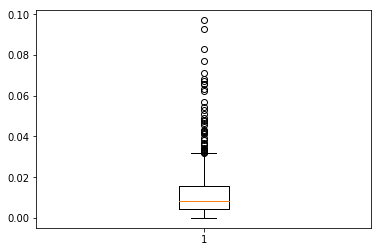

In [17]:
plt.boxplot(correlations)
plt.show()

In [18]:
## All correlations are really small but choose the best.

recipe_top_corr = recipe_data_features.loc[:, correlations.iloc[0, ] > 0.036]
recipe_top_corr.shape

(20052, 30)

In [19]:
x_2 = recipe_top_corr
y_2 = recipe_data_binary['rating_4plus']
svm_2 = SVC()
svm_2.fit(x_2, y_2)

/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [20]:
pd.crosstab(y_2, svm_2.predict(x_2))

col_0,0,1
rating_4plus,,
0,2404,6910
1,1598,9140


In [21]:
svm_2.score(x_2, y_2)

0.5757031717534411